In [2]:
import os
import glob
import torch
import numpy as np
import torchvision
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
CLASSES = ['camouflage', 'normal']
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.DEFAULT)
transform = torchvision.models.ViT_B_16_Weights.DEFAULT.transforms()

# Freeze all the params
for parameter in model.parameters():
    parameter.requires_grad = False

# Modify model head to include num classes
model.heads = torch.nn.Linear(in_features=768, out_features=len(CLASSES))

# Load trained weights
model.load_state_dict(torch.load('weights/model_best.pth'))

# Move model to GPU (if available)
model = model.to(device)

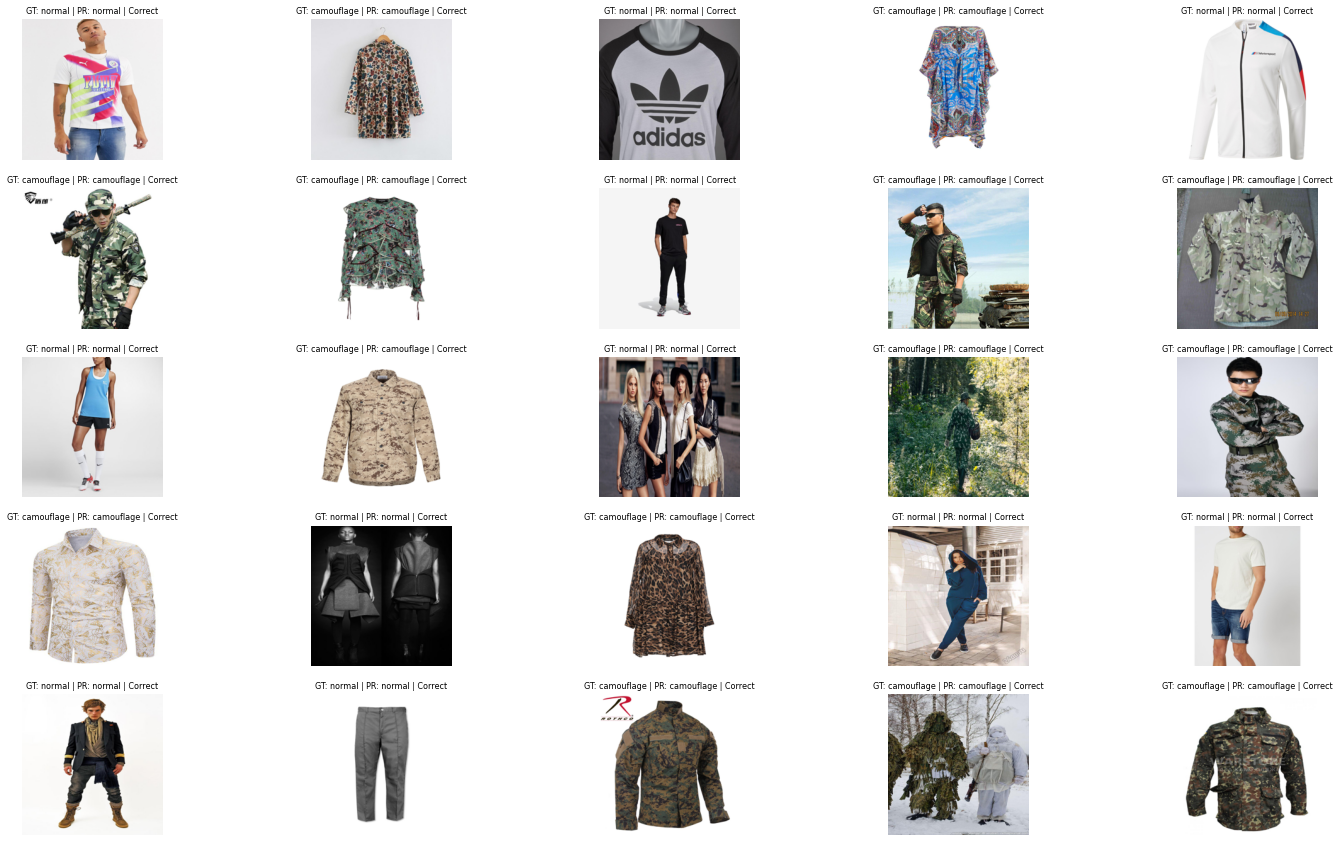

In [9]:
IMAGE_SIZE = 224
images = glob.glob("./dataset/val/*/*")

# Set the desired figure size
plt.figure(figsize=(25, 15))

# Choose 25 random images without replacement
selected_indices = np.random.choice(len(images), size=25, replace=False)

# Prepare a batch
batch_images = []
original_images = []
labels = []
for idx in selected_indices:
    path = images[idx]
    label = os.path.basename(os.path.dirname(path))
    image = Image.open(path).resize((IMAGE_SIZE, IMAGE_SIZE))
    original_images.append(image)
    image_tensor = transform(image).unsqueeze(dim=0)
    batch_images.append(image_tensor)
    labels.append(label)

# Concatenate all image tensors into a single batch tensor
batch_tensor = torch.cat(batch_images, dim=0).to(device)

# Make predictions for the entire batch
with torch.no_grad():
    preds = model(batch_tensor)
    pred_probs = torch.softmax(preds, dim=1)
    pred_labels = torch.argmax(pred_probs, dim=1)

# Convert predictions into class names
predicted_classes = [CLASSES[pred_label] for pred_label in pred_labels]

# Plot the original images and predictions
for i, (original_img, label, pred_label) in enumerate(zip(original_images, labels, predicted_classes)):
    plt.subplot(5, 5, i + 1)
    plt.imshow(original_img)  # Directly plot the original PIL image
    correct_status = 'Correct' if label == pred_label else 'Wrong'
    plt.title(f"GT: {label} | PR: {pred_label} | {correct_status}", fontdict={'fontsize': 8})
    plt.axis("off")

# Display the plot
plt.show()